# Machine Learning in Crowd Modelling and Simulation

In this task we implement a crowd simulation model using the cellular automata approach.
Our implementation can be run either by loading saved scenario files which are based on csv files or by the user detailing their own scenario.

Before moving ahead we import the key packages. It is best to install the required packages as detailed in the
`README.md` file with the help of the provided `requirements.txt` file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utilities import scenario_loader, scenario_builder
import csv
from utilities import parser_array2obj
from IPython.display import HTML
import pygame
import game_gui

YELLOW = '\033[93m'
ENDC = '\033[0m'

%reload_ext autoreload
%autoreload 2

pygame 2.0.2 (SDL 2.0.16, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html



## Task 1

We will implement the basics of our environment and show the outlook in this section. Here the user has two options

### Option 1: Load scenario
If you wish to load a scenario then type y in the following cell block. A list of available scenarios will be printed. Enter the id number of the scenario you wish to load and this will be loaded into a variable.


### Option 2: Make customer scenario
If you wish to make own scenario then type n in the following cell block. You will be asked for the size of the grid you wish to generate. Enter the row and column numbers. Finally a GUI will pop up. You can make a scenario there. Type in `P` to add a pedestrian, `O` for object and `T` for target. Please note all of these need to be in **upper case**. If you wish for a cell to remain empty you can leave it as it is. Once you are finished simply close the GUI. The scenario will be saved in a variable for further processing. 

**The initial state of the loaded/created scenario will be displayed.**

 Leave answers empty for default 
Do you want to load a scenario? (y/n)y
Available scenario files are: 
Scenario 0 :  chicken_test.csv
Scenario 1 :  chicken_test_multi_peds.csv
Scenario 2 :  multiple_targets.csv
Scenario 3 :  rimea_test1.csv
Scenario 4 :  task_1.csv
Please select which scenario you wish to load. Enter scenario id:3
Initial state of the loaded scenario:
Would you like to use Dijkstra-algorithm? (y/n)n
Maximum number of steps: (Positive integer)100


(28501, 39)

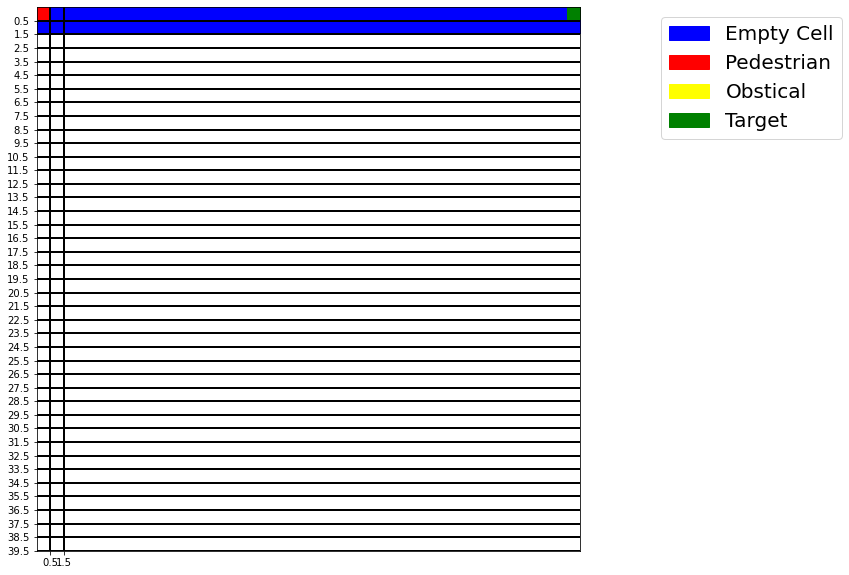

In [3]:
print(f"{YELLOW} Leave answers empty for default {ENDC}")
load_scenario_bool = input("Do you want to load a scenario? (y/n)")
    # Case if the user wishes to load a scenario saved in the scenario directory.
if load_scenario_bool == 'y':
    scenario = scenario_loader()
elif load_scenario_bool == 'n':
    scenario = scenario_builder()
else:
    scenario = scenario_builder()
#     assert False, "Incorrect input. Answer must be 'y' or 'n'. Please try again."
    
load_scenario_bool = input("Would you like to use Dijkstra-algorithm? (y/n)")
if load_scenario_bool == 'y':
    dijkstra = True
elif load_scenario_bool == 'n':
    dijkstra = False
else:
    dijkstra = False
#     assert False, "Incorrect input. Answer must be 'y' or 'n'. Please try again."
    
max_steps = input("Maximum number of steps: (Positive integer)")
    # Case if the user wishes to load a scenario saved in the scenario directory.
if max_steps.isdigit() and int(max_steps) >= 0:
    max_steps = int(max_steps)
else:
    max_steps = 100
#     assert False, "Incorrect input. Answer must be a positive integer. Please try again."

game_gui.start_game_gui(scenario, max_steps=max_steps, dijkstra=dijkstra)

## Task 2

### The simulation
We will now simulate the loaded scenario with our simple update step i.e. rudementary obstical avoidance and pedestrian repulsion.
The results will be visualized with the help of a matplotlib animation.

In [ ]:
states = scenario.simulate(25)


In [ ]:
a = scenario.animate()
# print(a)

## Task 3

## Task 4

### The Dijkstra's Algorithm
We implement the Dijkstra's algorithm to flood the cells with utilitiy values starting from the targets i.e. targets have a cost of 0. 

This allows a kind of look ahead when we simulate our pedestrians since now we have also taken into account the obsticals. Essentially the entire grid is treated as a well connected bi-directional graph instead of the points where the obsticals exist. These cells are treated as unconnected nodes on the graph. This is shown below:

<table>
  <tr>
    <td><img src="./figures/fully_connected.png" width=270 height=480></td>
    <td><img src="./figures/graph_with_obj.png" width=270 height=480></td>
  </tr>
      <tr>
    <td>Fully Connected Bi-Directional Graph</td>
     <td>Bi-directional Graph with Obstacle </td>
  </tr>
 </table>
 
We can show the result of the chicken test with the help of a color map.

In [ ]:
with open('./scenarios/multiple_targets.csv', newline='') as csvfile:
    chicken_test = np.array(list(csv.reader(csvfile))).astype(int)
    chicken_test = parser_array2obj(chicken_test)

plt.imshow(chicken_test.get_dijkstra())
plt.colorbar()

## Task 5

In [ ]:
### RiMEA 1